# Word2Vec

### Author: Cecília Assis
#### Github: https://github.com/ceciliassis
#### Linkedin: https://www.linkedin.com/in/ceciliassis/

In [1]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
logger = logging.getLogger(__name__)

In [144]:
HEADERS = {
    'User-Agent': (
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36'
        '(KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
    )
}

urls = [
    'https://take.net/blog/4devs/nlp-processamento-linguagem-natural/',
    'https://take.net/blog/4devs/nlp-chatbot/',
    'https://take.net/blog/4devs/cursos-para-aprender-sobre-chatbots/',
    'https://take.net/blog/inovacao/motivos-usar-inteligencia-artificial/',
    'https://take.net/blog/chatbots/algoritmos-inteligencia-artificial-crime/',
    'https://take.net/blog/chatbots/inteligencia-artificial-no-blip/',
    'https://take.net/blog/devs/trabalhar-com-inteligencia-artificial/',
    'https://take.net/blog/inovacao/sucesso-do-cliente-e-inteligencia-artificial/',
    'https://take.net/blog/take-test/testes-em-chatbots-com-nlp/',
    'https://take.net/blog/chatbots/chatbot/',
    'https://take.net/blog/inovacao/big-data/',
    'https://take.net/blog/inovacao/big-data-no-trabalho/',
    'https://take.net/blog/inovacao/transformacao-digital/'
]

In [3]:
# Define stric set of punctuations due to pre processing and Portuguese characteristics (ex. trata-se)
PUNCTUATIONS = ['*', '+', '.', '/', '[', ']', '(', ')', ';', ':', '%', 'º',
                '=', '!', '"','“', "'", "”", "#", '{', '}', ',', '\?']
PUNCTUATIONS_STR = ''.join(PUNCTUATIONS)

In [4]:
import spacy

# Load spacy lang
try:
    spacy.load('pt', disable=['ner'])
except OSError:
    !python -m spacy download pt
finally:
    PT_LANG = spacy.load('pt', disable=['ner'])

In [5]:
# Validade is a word is also a stopword
def is_stopword(word):
    return word in NLTK_STOPWORDS_TABLE

In [6]:
import nltk

# Add nltk stopwords to spacy
try:
    nltk.corpus.stopwords.words('portuguese')
except LookupError:
    nltk.download('stopwords')
finally:
    nltk_stopwords = nltk.corpus.stopwords.words('portuguese')
    
NLTK_STOPWORDS_TABLE = dict.fromkeys(i for i in nltk_stopwords)

stopwords_extension = ['desse', 'dessa', 'disso', 'dessas', 'desses', 
                       'esse', 'essa', 'nisso', 'nessa', 'nesse', 'deste', 'desta']

# Avoid akward spacy word break
for stopword in stopwords_extension:
    if not is_stopword(stopword):
        NLTK_STOPWORDS_TABLE[stopword] = None

In [7]:
import textacy.preprocessing
import ftfy

from readability import Document
from bs4 import BeautifulSoup

import requests

class Article():
    def __init__(self, url):
        self.url = url
        
    @property
    def html(self):
        if not hasattr(self, '_html'):
            self._html = self.get_html()
    
        return self._html
    
    
    @property
    def soup(self):
        if not hasattr(self, '_soup'):
            self._soup = self.get_soup()
    
        return self._soup
    
    @property
    def text(self):
        if not hasattr(self, '_text'):
            self._text = self.get_text()
    
        return self._text
    
    @property
    def spacy_doc(self):
        if not hasattr(self, '_spacy_doc'):
            self._spacy_doc = self.get_spacy_doc()
    
        return self._spacy_doc
    
    def get_html(self):
        article = requests.get(self.url, headers=HEADERS)
        
        return article.content
    
    
    def get_soup(self):
        soup = BeautifulSoup(self.html, 'html.parser')
        tags_to_remove = ['script', 'style', 'noscript', 
                          'aside', 'footer', 'header', 'div.newsletter']

        for tag in soup(tags_to_remove):
            tag.decompose()
            
        for tag in soup.find_all(class_='newsletter'):
            tag.decompose()
            
        document = Document(soup.encode(formatter="html5"))
        soup = BeautifulSoup(document.summary(), 'html.parser')
        
        return soup
        
        
    def get_text(self):
        text = self.soup.get_text("")
        text = text.lower()
        
        text = ftfy.fix_text(text)
        text = textacy.preprocessing.remove_punctuation(text, marks=PUNCTUATIONS_STR)
        text = textacy.preprocessing.replace_numbers(text, replace_with=' ')
        text = textacy.preprocessing.normalize_whitespace(text)

        text = text.split()
        text = ' '.join(word for word in text if not is_stopword(word))
        
        return text
    
    
    def get_spacy_doc(self):
        return textacy.make_spacy_doc(self.text, lang=PT_LANG)
    

#     ------------
    
def read_pages(urls):
    return [Article(url) for url in urls]

----

## Build corpora
Build corpora from posts

In [126]:
def build_corpus(pages, kwargs):
    return [
        list(page.spacy_doc._.to_terms_list(**kwargs))
        for page in pages
    ]

In [145]:
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec

pages = read_pages(urls)

kwargs = {'as_strings':True, 'normalize': None, 'ngrams':(1)}

corpus = build_corpus(pages, kwargs)
assert len(corpus) == len(pages)

INFO - 16:41:50: ruthless removal did not work. 
INFO - 16:41:50: Top 5 : 424.523 .entry-content-wrap>.entry-content
INFO - 16:41:50: Top 5 : 226.586 .entry-container>.entry-content-wrap
INFO - 16:41:50: Top 5 : 36.100 .post-inner>.entry-details
INFO - 16:41:50: Top 5 : 34.300 .post-inner>.entry-details
INFO - 16:41:50: Top 5 : 34.210 .post-inner>.entry-details
INFO - 16:41:55: ruthless removal did not work. 
INFO - 16:41:55: Top 5 : 102.768 .entry-content-wrap>.entry-content
INFO - 16:41:55: Top 5 : 65.152 .entry-container>.entry-content-wrap
INFO - 16:41:55: Top 5 : 36.100 .post-inner>.entry-details
INFO - 16:41:55: Top 5 : 34.300 .post-inner>.entry-details
INFO - 16:41:55: Top 5 : 34.210 .post-inner>.entry-details
INFO - 16:41:59: ruthless removal did not work. 
INFO - 16:41:59: Top 5 : 123.783 .entry-content-wrap>.entry-content
INFO - 16:41:59: Top 5 : 75.630 .entry-container>.entry-content-wrap
INFO - 16:41:59: Top 5 : 36.100 .post-inner>.entry-details
INFO - 16:41:59: Top 5 : 34.

## Retrieve unigrams and bigrams from vocab
After building the corpora, the senteces are passed to gensim's Phrases model that detects common phrases and its ngrams.

In [146]:
phrases = Phrases(corpus)
sentences = phrases[corpus]

INFO - 16:42:14: collecting all words and their counts
INFO - 16:42:14: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:42:14: collected 9172 word types from a corpus of 7235 words (unigram + bigrams) and 13 sentences
INFO - 16:42:14: using 9172 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10.0, max_vocab_size=40000000>


## Build model vocab
Buuild the model vocabulary based on the sentences previously created.

In [148]:
# Build model vocab
from time import time

w2v_model = Word2Vec()

t = time()
w2v_model.build_vocab(sentences)
print(f'Time to build vocab: {round((time() - t) / 60, 2)} mins')

print(f'Vocabulary size: {len(w2v_model.wv.vocab)} word')

INFO - 16:42:37: collecting all words and their counts
INFO - 16:42:37: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:42:37: collected 2661 word types from a corpus of 7017 raw words and 13 sentences
INFO - 16:42:37: Loading a fresh vocabulary
INFO - 16:42:37: effective_min_count=5 retains 331 unique words (12% of original 2661, drops 2330)
INFO - 16:42:37: effective_min_count=5 leaves 3578 word corpus (50% of original 7017, drops 3439)
INFO - 16:42:37: deleting the raw counts dictionary of 2661 items
INFO - 16:42:37: sample=0.001 downsamples 123 most-common words
INFO - 16:42:37: downsampling leaves estimated 2719 word corpus (76.0% of prior 3578)
INFO - 16:42:37: estimated required memory for 331 words and 100 dimensions: 430300 bytes
INFO - 16:42:37: resetting layer weights


Time to build vocab: 0.0 mins
Vocabulary size: 331 word


## Train model
Train the Word2Vec model, using the following parameters:

- `size`: 100 (dimensionality of the word vectors)
- `alpha`: 0.025 (initial learning rate)
- `window`: 5 (maximum distance between the current and predicted word within a sentence)
- `seed`: 1 (random generator seed for reproducibility)
- `min_alpha`: 0.0001 (learning rate lower bound)
- `min_count`: 5 (word frequency lower bound)
- `negative`: 5 (if > 0, sets how many “noise words” should be drawn (usually between 5-20))
- `epochs`: 30 (number of epochs, i.e. iterations, over the corpus)
- `report_delay`: 1 (seconds to wait before reporting progress)

In [149]:
# Train model
t = time()

w2v_model.train(sentences, 
                total_examples=w2v_model.corpus_count, 
                epochs=30, 
                report_delay=1)

print(f'Time to train the model: {round((time() - t) / 60, 2)} mins')

INFO - 16:42:41: training model with 3 workers on 331 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 16:42:41: worker thread finished; awaiting finish of 2 more threads
INFO - 16:42:41: worker thread finished; awaiting finish of 1 more threads
INFO - 16:42:41: worker thread finished; awaiting finish of 0 more threads
INFO - 16:42:41: EPOCH - 1 : training on 7017 raw words (2669 effective words) took 0.0s, 60599 effective words/s
INFO - 16:42:41: worker thread finished; awaiting finish of 2 more threads
INFO - 16:42:41: worker thread finished; awaiting finish of 1 more threads
INFO - 16:42:41: worker thread finished; awaiting finish of 0 more threads
INFO - 16:42:41: EPOCH - 2 : training on 7017 raw words (2744 effective words) took 0.1s, 53094 effective words/s
INFO - 16:42:41: worker thread finished; awaiting finish of 2 more threads
INFO - 16:42:41: worker thread finished; awaiting finish of 1 more threads
INFO - 16:42:41: worker thread finished;

INFO - 16:42:43: worker thread finished; awaiting finish of 2 more threads
INFO - 16:42:43: worker thread finished; awaiting finish of 1 more threads
INFO - 16:42:43: worker thread finished; awaiting finish of 0 more threads
INFO - 16:42:43: EPOCH - 25 : training on 7017 raw words (2700 effective words) took 0.1s, 51613 effective words/s
INFO - 16:42:43: worker thread finished; awaiting finish of 2 more threads
INFO - 16:42:43: worker thread finished; awaiting finish of 1 more threads
INFO - 16:42:43: worker thread finished; awaiting finish of 0 more threads
INFO - 16:42:43: EPOCH - 26 : training on 7017 raw words (2721 effective words) took 0.0s, 62032 effective words/s
INFO - 16:42:43: worker thread finished; awaiting finish of 2 more threads
INFO - 16:42:43: worker thread finished; awaiting finish of 1 more threads
INFO - 16:42:43: worker thread finished; awaiting finish of 0 more threads
INFO - 16:42:43: EPOCH - 27 : training on 7017 raw words (2712 effective words) took 0.0s, 6300

Time to train the model: 0.03 mins


In [150]:
# Pre compute L2-normalized vector
# After this call, no more training can be done

w2v_model.wv.init_sims(replace=True)

INFO - 16:42:50: precomputing L2-norms of word weight vectors


## Vector representation
Since Word2Vec model assignsa vector representation to each word, below are some of them.

In [151]:
w2v_model.wv.vocab.keys()

dict_keys(['nlp', 'natural', 'processamento_linguagem', 'português', 'tecnologia', 'usada', 'ajudar', 'linguagem', 'humano', 'maneira', 'responder', 'demandas', 'processo', 'simples', 'aplicativos', 'realizar', 'pesquisa', 'google', 'receber', 'resposta', 'qualidade', 'usam', 'linguagens', 'diferentes', 'preciso', 'permitir', 'compreensão', 'máquina', 'melhor', 'experiência', 'usuário', 'conversa', 'texto', 'inteligência_artificial', 'ia', 'desenvolver', 'capacidade', 'entender', 'seres_humanos', 'diferença', 'linguagem_natural', 'programação', 'humanos', 'pessoas', 'máquinas', 'comuns', 'podemos', 'criar', 'sistemas', 'aplicações', 'permite', 'entenda', 'usando', 'respostas', 'interações', 'exemplos', 'aplicação', 'chatbot', 'empresa', 'capaz', 'informações', 'contato', 'usuários', 'estrutura', 'complexos', 'sendo', 'possa', 'humana', 'conceitos', 'processamento', 'machine_learning', 'deep', 'learning', 'ml', 'aprendizado_máquina', 'assunto', 'redes', 'neurais', 'melhorar', 'fala', 'l

In [75]:
def print_w2v(w2v_model, word):
    print(f'Vector of word "{word}"')
    print(w2v_model.wv.word_vec(word))

In [152]:
print_w2v(w2v_model, 'nlp')
print_w2v(w2v_model, 'machine_learning')

Vector of word "nlp"
[-0.01367724 -0.10155511  0.10198835  0.05174489 -0.02064996 -0.06888045
  0.0917024   0.00657047  0.08956663 -0.10079786  0.06602094 -0.04387011
  0.06406075  0.04032032 -0.3385873   0.12747309  0.01690682 -0.07733346
  0.09725036  0.00933549 -0.01242094 -0.04173902  0.00922961  0.05799652
  0.02354773  0.01053208  0.09002472 -0.01564538 -0.04094705  0.12618802
  0.02093946  0.07107322  0.06840596 -0.10924128 -0.0025774   0.23926401
  0.02513755  0.14137061  0.05418982 -0.01937499  0.06024384  0.05843498
  0.02578603 -0.24919648  0.08957507  0.04937788  0.04689065  0.16278632
  0.01517398  0.00134025  0.025291    0.06629166  0.17440996 -0.02583305
 -0.04185402  0.01607129 -0.04789976  0.04187287 -0.05154903 -0.01857959
 -0.10567098 -0.05169498  0.1019692   0.03813137  0.07841473  0.01523525
  0.09451906  0.04989419  0.1304131  -0.00731087 -0.07391549 -0.00334188
  0.09981506  0.04363726 -0.04423853 -0.14855962 -0.08031429  0.24405386
  0.10387704 -0.02796236 -0.07

## Most similar
Word embeddings enables us to find similarities along the vector space through calculations such as cosine one. Below we have top 10 similar word for 3 words present in the vocabulary.

In [141]:
def top_10_similar(w2v_model, word):
    words = w2v_model.wv.most_similar(positive=[word])
    words = [w[0] for w in words]
    print(f'Top 10 similar words for {word}: {words}')

In [160]:
top_10_similar(w2v_model, 'aprender')
top_10_similar(w2v_model, 'machine_learning')
top_10_similar(w2v_model, 'inteligência_artificial')

Top 10 similar words for aprender: ['criar', 'ia', 'inteligência_artificial', 'agentes', 'melhor', 'evolução', 'palavras', 'importante', 'objetivo', 'funciona']
Top 10 similar words for machine_learning: ['hoje', 'principais', 'nlp', 'ferramentas', 'compreensão', 'artificial', 'aprendizado_máquina', 'linguagem', 'tecnologia', 'provedor']
Top 10 similar words for inteligência_artificial: ['aprender', 'compreender', 'agentes', 'máquina', 'objetivo', 'ia', 'conteúdos', 'usuários', 'situação', 'prática']


## Analogy difference
Vector representations also enables us to sum and/or subtract words from other, leading to highly informative concepts as shown below.

In [104]:
def vector_association(w2v_model, positive_words, negative_word):
    words = w2v_model.wv.most_similar(positive=positive_words, 
                                      negative=[negative_word],
                                      topn=1)
    words = [w[0] for w in words]
    print(f'Which word is to "{positive_words[0]}" as "{positive_words[1]}" is to "{negative_word}"? {words}')

In [156]:
vector_association(w2v_model, ['chatbots', 'machine_learning'], 
                   'inteligência_artificial')

vector_association(w2v_model, ['usuário', 'nlp'], 
                   'inteligência_artificial')

Which word is to "chatbots" as "machine_learning" is to "inteligência_artificial"? ['mundo']
Which word is to "usuário" as "nlp" is to "inteligência_artificial"? ['resposta']


## Odd-One-Out
If we want to know the word that deviates the most from a list of terms, we can ask for the most odd one

In [115]:
def odd_one_out(w2v_model, words):
    word = w2v_model.wv.doesnt_match(words)
    print(f"Which word doesn't fit in the list: {words}? {word}")

In [157]:
odd_one_out(w2v_model, ['nlp', 'inteligência_artificial', 'evento'])

Which word doesn't fit in the list: ['nlp', 'inteligência_artificial', 'evento']? evento


/home/ceciliassis/pessoal/machine-learning/natural-language-processing/word2vec/venv/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


## t-SNE visualization
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a technique for dimensionality reductition. Since humans are more confortable with spaces up to 3 dimensions, this kind of method helps to see how data fit on the explored vector space. 

For more info, see [Visualising high-dimensional datasets using PCA and t-SNE in Python](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b) and [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

print(f'Current word embedding dimension: {w2v_model.wv.get_vector("nlp").shape}')

Current word embedding dimension: (100,)


In [35]:
def tsne_representation(w2v_model, word):
    w2v_labels = [word]
    w2v_colors = ['red']
    w2v_arrays = np.empty((0,100), dtype='f')

    w2v = w2v_model.wv.word_vec("nlp")
    w2v_arrays = np.append(w2v_arrays, [w2v], axis=0) 

    # Add similar words to w2v array
    most_similar = w2v_model.wv.most_similar([word])
    w2v_colors.extend(['black'] * len(most_similar))
    for word_score in most_similar:
        w2v_labels.append(word_score[0])
        w2v = w2v_model.wv.word_vec(word_score[0])
        w2v_arrays = np.append(w2v_arrays, [w2v], axis=0)
    
    # reduce w2v dims
    t = time()
    pca = PCA(n_components=5).fit_transform(w2v_arrays)
    print(f'Time to train PCA: {round((time() - t) / 60, 2)} mins')
    
    t = time()
    tsne = TSNE(n_components=2, random_state=0).fit_transform(pca)    
    print(f'Time to train TSNE: {round((time() - t) / 60, 2)} mins')
    
    tsne_dataframe = pd.DataFrame({'x': [x for x in tsne[:, 0]],
                                   'y': [y for y in tsne[:, 1]],
                                   'word': w2v_labels,
                                   'color': w2v_colors})
    
    # Define plot
    fig = plt.figure(figsize=(10, 10))
    
    plot = sns.regplot(data=tsne_dataframe,
                       x='x', 
                       y='y',
                       fit_reg=False, 
                       marker='o', 
                       scatter_kws={
                        's': 40, 
                           'facecolors': tsne_dataframe['color']
                       })
    
    
    # Set annotations
    for line in range(0, tsne_dataframe.shape[0]):
        plt.text(tsne_dataframe['x'][line], 
                tsne_dataframe['y'][line], 
                ' ' + tsne_dataframe['word'][line],
                horizontalalignment='left',
                verticalalignment='bottom', 
                size='medium',
                color=tsne_dataframe['color'][line],
                weight='normal'
               ).set_size(15)
        
    plt.title(f't-SNE visualization for {word}')

Time to train PCA: 0.0 mins
Time to train TSNE: 1.22 mins


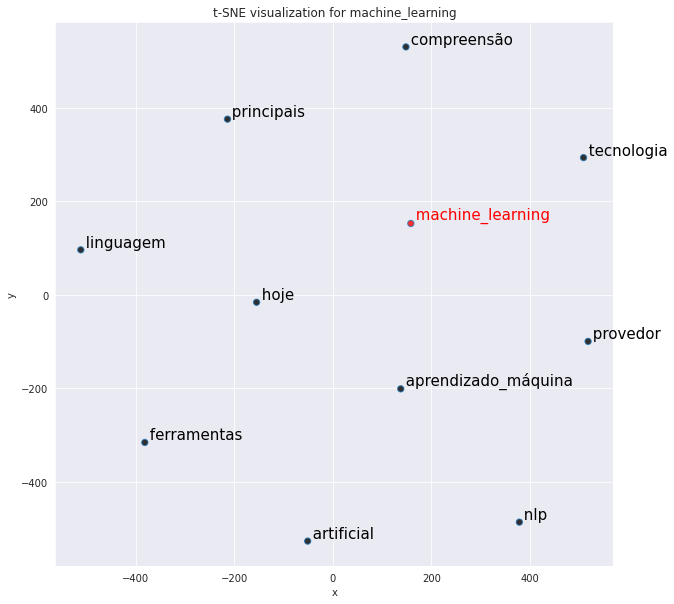

In [158]:
tsne_representation(w2v_model, 'machine_learning')

Time to train PCA: 0.0 mins
Time to train TSNE: 1.34 mins


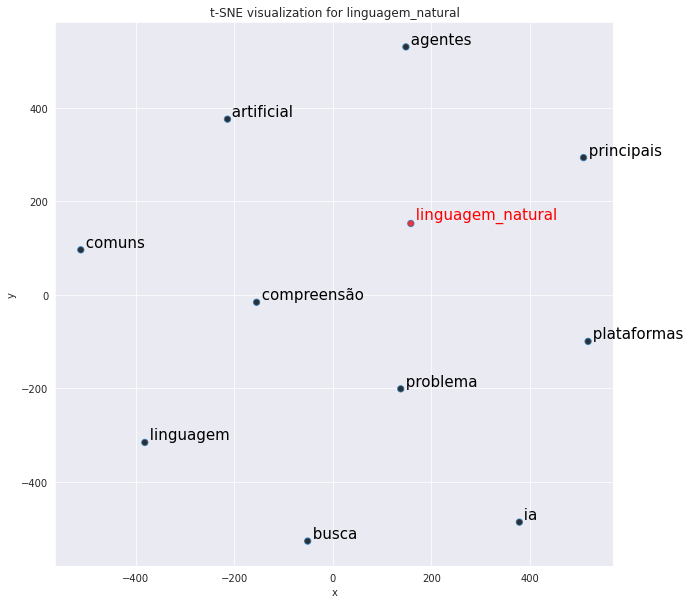

In [159]:
tsne_representation(w2v_model, 'linguagem_natural')

## Summary
Word embeddings allows us to match words against their context, enabling important discoveries.

### Thanks to:
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial